<a href="https://www.kaggle.com/code/ricdur/defensive-tackling-contribution-dtc?scriptVersionId=159067730" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Intro

Tackles are arguably the most basic individual defensive statistic to track in a football game. However, tracking the statistic can be more complicated than expected. Articles have addressed topics like [discrepancies in individual tackles between coaches and gamebooks](https://nflfootballjournal.blogspot.com/2017/09/the-tale-of-two-tackles-sources.html), [tackle bias in stat crews](https://www.pff.com/news/nfl-stats-crew-tackle-bias), and [inconsistencies of tackle assists](https://www.si.com/nfl/2015/09/18/nfl-tackling-history-stat-leaders-lavonte-david). NFL tackle statistics are counted and recorded, but the numbers can vary depending on who's doing the counting. For example, here we see the top 5 tacklers across weeks 7-9 in 2022 according to Pro Football Focus (PFF), NFL.com, and Pro Football Reference. Despite all being reputable sources,each show discrepancies in the data. 

Links: [NFL1](https://www.nfl.com/players/shaq-thompson/stats/logs/2022/), [PFR1](https://www.pro-football-reference.com/players/T/ThomSh01/gamelog/2022/)
[NFL2](https://www.nfl.com/players/Rashaan-evans/stats/logs/2022/), [PFR2](https://www.pro-football-reference.com/players/E/EvanRa01/gamelog/2022/)
[NFL3](https://www.nfl.com/players/Grover-Stewart/stats/logs/2022/), [PFR3](https://www.pro-football-reference.com/players/S/StewGr00/gamelog/2022/)
[NFL4](https://www.nfl.com/players/Quay-Walker/stats/logs/2022/), [PFR4](https://www.pro-football-reference.com/players/W/WalkQu00/gamelog/2022/)
[NFL5](https://www.nfl.com/players/foye-oluokun/stats/logs/2022/), [PFR5](https://www.pro-football-reference.com/players/O/OluoFo00/gamelog/2022/)

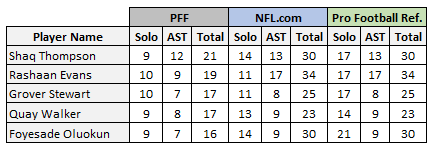

In [1]:
from IPython.display import Image
Image("/kaggle/input/pff-nfl-pfr/PFF_NFL_PFR.png")

Assigning credit to which defender is responsible for a tackle can be a complicated task. In addition to the inconsistencies mentioned, the defensive players influencing the tackle might not be assigned any credit. Defenders do not get tackling credit for setting the edge, forcing the ball carrier to stop and change directions, or taking on multiple blockers to allow another defender to make the tackle. This work looks to address both issues by creating a Defensive Tackling Contribution metric (DTC) to assign defenders a proportion of credit for each tackle made. For simplicity of the analysis, only plays that include the ball carrier getting a handoff are considered. However, a similar process could be implemented for all plays.

# Data

To create this Defensive Tackling Contribution (DTC) metric, the data was simplified to only include runs made that had a single handoff. The data spanned from when the ball carrier received the handoff, and ended when the ball carrier fumbled, ran out of bounds, or was tackled. Additionally, the player data was eventually filtered down to the following players: 1) ball carrier, 2) the 3 closest defenders, 3) the closest offensive player to the ball carrier (not including QB), and 4) the two closest offensive players to each of the three closest defenders (besides the QB, ball carrier, and the nearest offensive player to the ball carrier). The primary data points centered around the location of the ball carrier, the distance and angle of the defenders to the ball carrier, the distance and angle of the defenders to their nearest two offensive players, as well as the nearest offensive player to the ball carrier (not including QB). Additional data includes the speed and acceleration of the ball carrier and defenders, the ball carrier's distance to the end zone, and the number of frames since the ball carrier received the handoff. 


# Process

The process to get the DTC metric consists of three main steps:

- 1) Build a model to predict how much further the ball carrier would go at any given location
- 2) Use the model's SHAP values to estimate each player's contribution to potentially stopping the ball carrier
- 3) For the final 15 frames, use the negative SHAP values and certain criteria to estimate the contribution to the tackle on the play


### 1) Model and Results


An XGBoost model was selected to build a predictive model to estimate how much further the ball carrier would go, given the locations of the players and other attributes mentioned above. The model was trained using data from weeks 1-6. The resulting model was able to obtain the following metrics on the weeks 1-6 test data. The data was unsurprisingly not as successful when using data from weeks 7-9, as shown here. With more time to spend on the model, these metrics could be improved. However, for the purpose of this metric, the results were useful enough to get meaningful insights. The predictions were directionally correct and sought to find a balance of incorporating the complexity of all variables available, while simplifying as much as possible. A difficulty in building such a predictive model is a player can be predicted to be brought down in two more yards, but a spectacular move by the ball carrier might lead to significantly more yards. The graph below the model results shows the player movements on a play from week 7. This model was used to obtain SHAP values that could then be used to seek to determine on a frame-by-frame basis which players are helping the ball carrier get tackled.

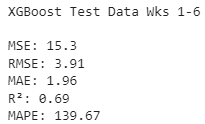

In [2]:
from IPython.display import Image
Image("/kaggle/input/xg-results/xg 1-6.png")

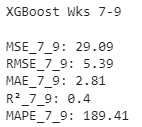

In [3]:
from IPython.display import Image
Image("/kaggle/input/xg-results/xg7-9.png")

In [4]:
!pip install plotly
!pip install dash

import plotly
import pandas as pd
import numpy as np
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px


games = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2024/games.csv")
players = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2024/players.csv")
plays = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2024/plays.csv")
tackles = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2024/tackles.csv")


all_players_sorted_7 = pd.read_pickle("/kaggle/input/all-players-sorted-and-df-all/all_players_sorted_7.pkl")
all_players_sorted_8 = pd.read_pickle("/kaggle/input/all-players-sorted-and-df-all/all_players_sorted_8.pkl")
all_players_sorted_9 = pd.read_pickle("/kaggle/input/all-players-sorted-and-df-all/all_players_sorted_9.pkl")
df_all = pd.read_pickle("/kaggle/input/all-players-sorted-and-df-all/df_all.pkl")

results_df_7_9 = pd.read_csv("/kaggle/input/final-data/results_df_7_9.csv")
tackle_data = pd.read_csv("/kaggle/input/final-data/tackle_data.csv")
conf_div = pd.read_csv("/kaggle/input/final-data/conf_div.csv")
df_shap_final_pbp = pd.read_csv("/kaggle/input/final-data/df_shap_final_pbp.csv")
shap_values_7_9 = pd.read_csv("/kaggle/input/final-data/shap_values_7_9.csv")

players_within_3_5_wks_7_9 = pd.read_pickle("/kaggle/input/players-within-3-5-wks-7-9/players_within_3_5_wks_7_9.pkl")

all_predicted_7 = results_df_7_9[['gameId', 'playId', 'frameId', 'Predicted']].merge(all_players_sorted_7, on=['gameId', 'playId', 'frameId'], how='inner')



def polar_to_cartesian(row):
    # Convert angle to radians and calculate x, y coordinates
    angle_rad = np.radians(row['angle_for_min_distance'])
    x = row['std_x_nb'] + row['min_distance'] * np.cos(angle_rad)
    y = row['std_y_nb'] + row['min_distance'] * np.sin(angle_rad)
    return x, y

def polar_to_cartesian_2(row):
    # Convert angle to radians and calculate x, y coordinates
    angle_rad = np.radians(row['angle_for_second_min_distance'])
    x = row['std_x_nb'] + row['second_min_distance'] * np.cos(angle_rad)
    y = row['std_y_nb'] + row['second_min_distance'] * np.sin(angle_rad)
    return x, y


df_7 = all_predicted_7[['gameId','playId','frameId','Predicted',
 'dist_to_ball',
 'ang_to_ball',
 'within_3_yds',
 'within_5_yds',
 'frame_since_bc',
 'rank',
 'new_pos',
 'x_no_1',
 'y_no_1',
 'min_distance',
 'angle_for_min_distance',
 'second_min_distance',
 'angle_for_second_min_distance',
 'max_distance',
 'actual_dist_from_final',
 'std_x_nb',
 'std_y_nb',
 'std_bc_x',
 'std_bc_y']]


df_7['closest_o_x'], df_7['closest_o_y'] = zip(*all_predicted_7.apply(polar_to_cartesian, axis=1))
df_7['second_closest_o_x'], df_7['second_closest_o_y'] = zip(*all_predicted_7.apply(polar_to_cartesian_2, axis=1))

df_7 = df_7[df_7['rank'] > 1.5]


  Obtaining dependency information for dash from https://files.pythonhosted.org/packages/7b/62/438626ab498869249e99376684ba6d88931e7c2dd86d03a92d9d7a9b4c54/dash-2.14.2-py3-none-any.whl.metadata
  Obtaining dependency information for ansi2html from https://files.pythonhosted.org/packages/42/d7/1bc3433a2406b891182c25a7926abe3eb19af5870d540375ebf7795885b3/ansi2html-1.9.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 58.4 MB/s eta 0:00:00


/tmp/ipykernel_19/1791017491.py:8: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/tmp/ipykernel_19/1791017491.py:9: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/tmp/ipykernel_19/1791017491.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7['closest_o_x'], df_7['closest_o_y'] = zip(*all_predicted_7.apply(polar_to_cartesian, axis=1))
/tmp/ipykernel_19/1791017491.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [5]:
import plotly.graph_objects as go

# Filter for a specific play
specific_game_id = 2022102300
specific_play_id = 388
play_data = df_7[(df_7['gameId'] == specific_game_id) & (df_7['playId'] == specific_play_id)]

# Get unique frames
unique_frames = sorted(play_data['frameId'].unique())

# Initialize the figure
fig = go.Figure()

# Create frames for each unique frame in the play
frames = []
for frame_id in unique_frames:
    frame_data = play_data[play_data['frameId'] == frame_id]
    frame_traces = []

    # Add trace for defensive player
    frame_traces.append(
        go.Scatter(
            x=frame_data['std_x_nb'],
            y=frame_data['std_y_nb'],
            mode='markers',
            marker=dict(size=10, color='blue', symbol='circle'),
            name='Defensive Player'
        )
    )

    # Add trace for ball carrier
    frame_traces.append(
        go.Scatter(
            x=frame_data['std_bc_x'],
            y=frame_data['std_bc_y'],
            mode='markers',
            marker=dict(size=12, color='red', symbol='star'),
            name='Ball Carrier'
        )
    )

    # Add traces for offensive players
    for col_x, col_y in [('x_no_1', 'y_no_1'), ('closest_o_x', 'closest_o_y'), ('second_closest_o_x', 'second_closest_o_y')]:
        if col_x in frame_data and col_y in frame_data:
            frame_traces.append(
                go.Scatter(
                    x=frame_data[col_x],
                    y=frame_data[col_y],
                    mode='markers',
                    marker=dict(size=8, color='green', symbol='square'),
                    name='Offensive Player'
                )
            )


    frames.append(go.Frame(data=frame_traces, name=str(frame_id)))

    # Calculate positions for vertical lines
    ball_carrier_x = frame_data['std_bc_x'].iloc[0]  # Assuming there's only one ball carrier per frame
    actual_line_x = ball_carrier_x - frame_data['actual_dist_from_final'].iloc[0]
    predicted_line_x = ball_carrier_x - frame_data['Predicted'].iloc[0]

    
    
    # Add vertical lines as shapes
    frame_shapes = [
        go.layout.Shape(
            type="line",
            x0=actual_line_x, y0=0, x1=actual_line_x, y1=55,  # y1 should be the top of your y-axis
            line=dict(color="yellow", width=2)
        ),
        go.layout.Shape(
            type="line",
            x0=predicted_line_x, y0=0, x1=predicted_line_x, y1=55,
            line=dict(color="white", width=2)
        )
    ]

    
    
    # Add annotations for the actual and predicted lines
    frame_annotations = [
        go.layout.Annotation(
            x=actual_line_x,
            y=max(frame_data['std_y_nb']),  # or another suitable y-coordinate
            text="Actual",
            showarrow=True,
            arrowhead=1,
            ax=-150  # Adjust this for proper positioning
        ),
        go.layout.Annotation(
            x=predicted_line_x,
            y=max(frame_data['std_y_nb']),  # or another suitable y-coordinate
            text="Predicted",
            showarrow=True,
            arrowhead=1,
            ax=-30  # Adjust this for proper positioning
        )
    ]

    # Add this set of traces as a frame with shapes and annotations
    frames.append(go.Frame(data=frame_traces, name=str(frame_id), layout=go.Layout(shapes=frame_shapes, annotations=frame_annotations)))
    
    
# Set frames to the figure
fig.frames = frames

# Update layout for animation
fig.update_layout(
    title=f'G.Edwards for 12 yards, BAL vs. CLE Q1 7:10',
    xaxis=dict(title='Yards From Endzone', range=[0, 110]),
    yaxis=dict(title='Yards Sideline to Sideline', range=[0, 55]),
    updatemenus=[{
        'type': 'buttons',
        'buttons': [{
            'label': 'Play',
            'method': 'animate',
            'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}]
        }]
    }],
    sliders=[{
        'steps': [{'method': 'animate', 'args': [[str(frame_id)], {'mode': 'immediate', 'frame': {'duration': 500, 'redraw': True}}], 'label': str(frame_id)} for frame_id in unique_frames]
    }]
)

# Initialize the figure with the first frame's data
initial_frame_data = play_data[play_data['frameId'] == unique_frames[0]]
fig.add_traces(frames[0]['data'])

fig.show()


### 2) SHAP

Shap values for the XGBoost model were calculated for each frame by player. The data was filtered for the final 15 frames (1.5 seconds) of the play when the ball carrier is primarily going down. Logic was implemented to cutoff plays once the ball carrier reached the final 'x' and 'y' location on the play to eliminate instances where defenders get close after the play is over. 

### 3) Addition Logic

To calculate the Defensive Tackle Contribution (DTC) metric, defenders who had a combined SHAP attribute score < 0 were tracked over the last 15 frames of the play. Then, if a defender had at least 10% of the negative SHAP value on the play, they were eligible to be counted towards the DTC total. Finally, for each defender that accounted for at least 10% of the negative SHAP values, each player's contribution to that is their sum total DTC. This can be thought of as a percentage of a traditional tackle.


### Metrics and Insights

Once the DTC metric is calculated, it allows for further insights to be gathered on certain types of play. Players primarily responsible for the ball carrier going down can receive attribution, and is not limited to only 2 defenders, like traditional tackle assists. Furthermore, it removes inconsistencies that can be found across different stadiums that may be more strict or lenient in who they assign an assisted tackle to.

Here is additional insights on the top five tacklers shared from before. By taking the DTC, we can look at the number of instances a player contributes to a tackle, as well as calculate their summed tackling contribution. Here, it's combined with data across tackles for loss, 3rd/4th down stops, goal-to-go situations, and positive and negative EPA to determine the number of contributions, the sum of these contributions, and estimate the EPA impact.

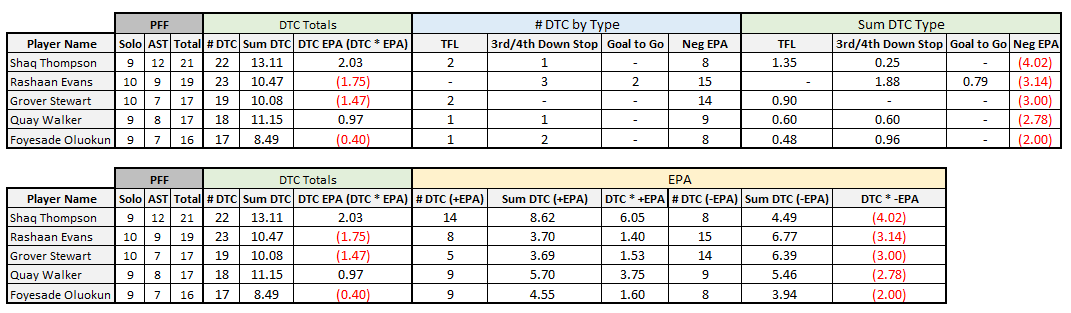

In [6]:
from IPython.display import Image
Image("/kaggle/input/top-5-tacklers/Top5.png")

Below, the same type of analysis can be seen looking at the Arizona Cardinals defense from weeks 7-9.

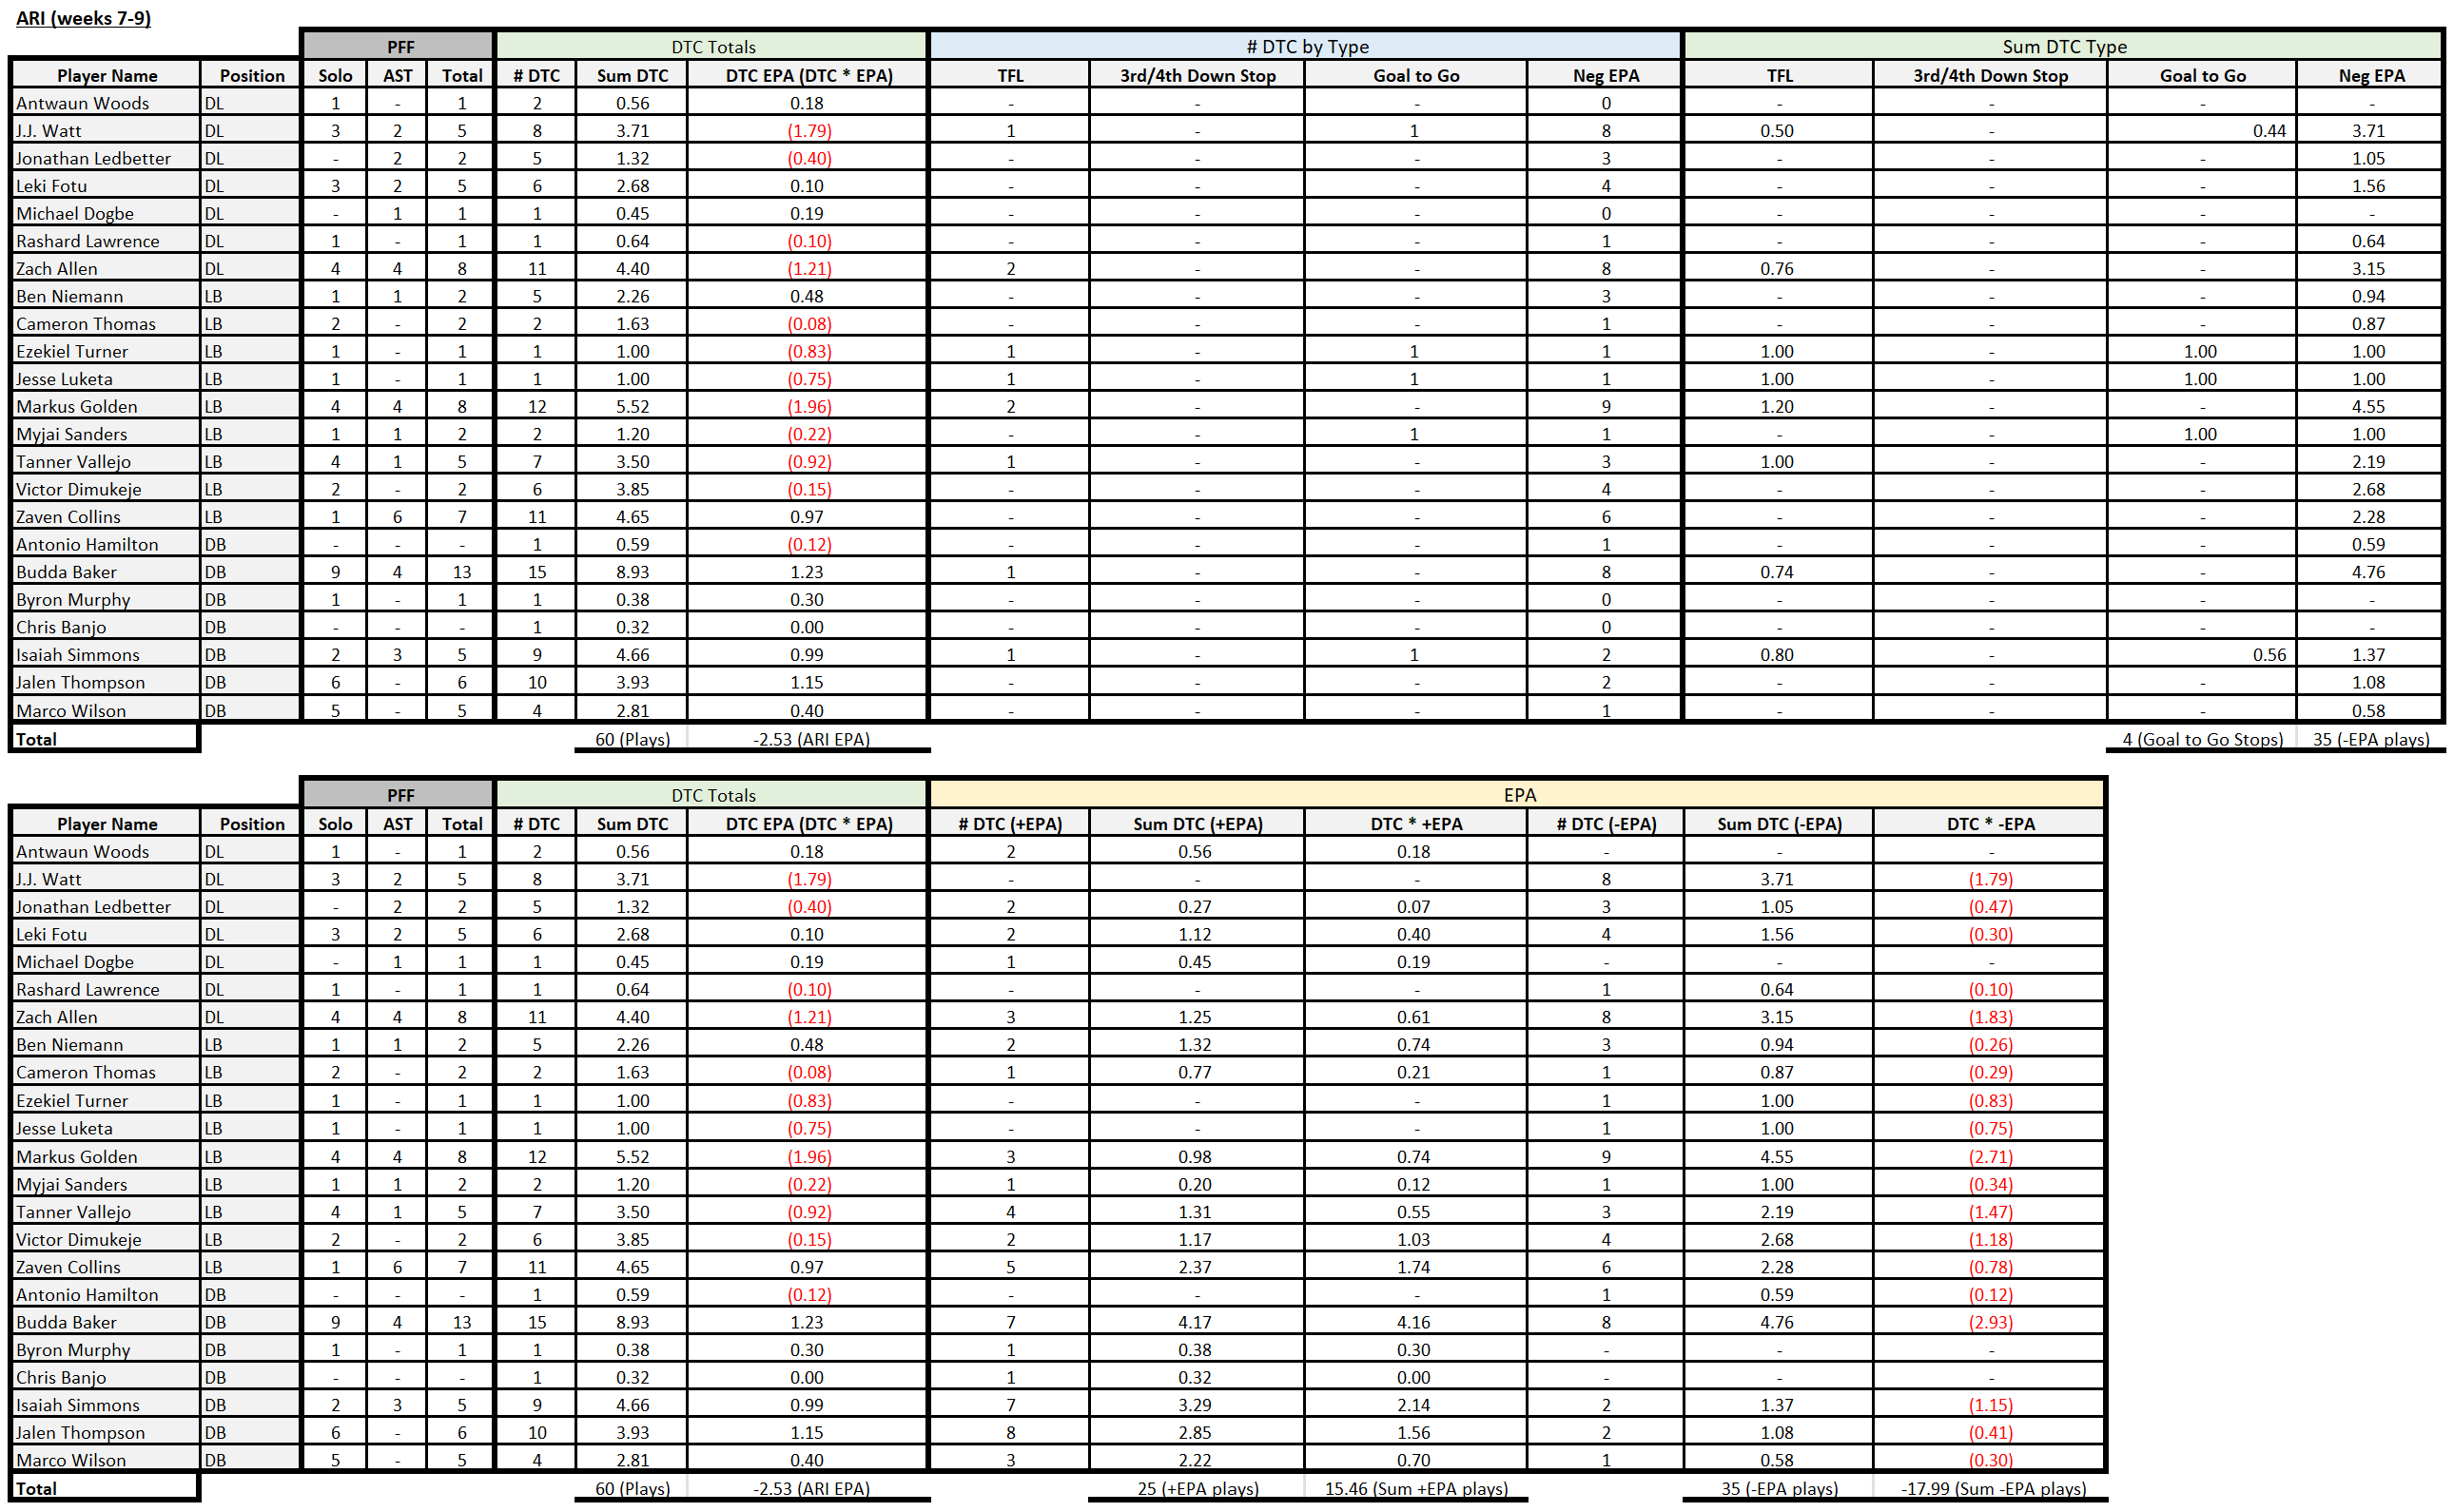

In [7]:
from IPython.display import Image
Image("/kaggle/input/arizona-def/ARI 2.png")

This type of analysis can be beneficial in comparing contributions by DL/LB/DB position groups by the team relative to the NFL (weeks 7-9 here).

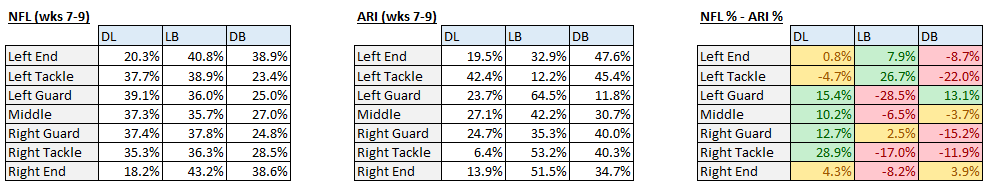

In [8]:
from IPython.display import Image
Image("/kaggle/input/nfl-ari/NFL_ARI.png")


The final metrics take into account the amount of time a defender or team spends within 3 yards of the ball carrier. 

In [9]:
ARI_players = ['Antwaun Woods', 'J.J. Watt', 'Jonathan Ledbetter', 'Leki Fotu', 'Michael Dogbe', 'Rashard Lawrence', 'Zach Allen', 'Ben Niemann', 'Cameron Thomas', 'Ezekiel Turner', 'Jesse Luketa',
               'Markus Golden', 'Myjai Sanders', 'Tanner Vallejo', 'Victor Dimukeje', 'Zaven Collins', 'Antonio Hamilton', 'Budda Baker', 'Byron Murphy', 'Chris Banjo', 'Isaiah Simmons', 'Jalen Thompson', 'Marco Wilson']


ARI_players_within_3_5_wks_7_9 = players_within_3_5_wks_7_9[players_within_3_5_wks_7_9['defensiveTeam'] == 'ARI']



name_pos_plays = ARI_players_within_3_5_wks_7_9.groupby(['displayName', 'new_pos'])['playId'].nunique().reset_index().sort_values(['playId'], ascending=False).reset_index(drop=True)
name_pos_plays = name_pos_plays.rename(columns={'displayName': 'Name', 'new_pos': 'Pos', 'playId': '# Plays'})

name_pos_sec = ARI_players_within_3_5_wks_7_9.groupby(['displayName', 'new_pos'])['frameId'].count().reset_index().sort_values(['frameId'], ascending=False).reset_index(drop=True)
name_pos_sec = name_pos_sec.rename(columns={'displayName': 'Name', 'new_pos': 'Pos', 'frameId': 'Total Time'})
name_pos_sec['Total Time'] = name_pos_sec['Total Time'] / 10

name_pos_wi_5 = ARI_players_within_3_5_wks_7_9[ARI_players_within_3_5_wks_7_9['within_5_yds'] == 1].groupby(['displayName', 'new_pos'])['frameId'].count().reset_index().sort_values(['frameId'], ascending=False).reset_index(drop=True)
name_pos_wi_5 = name_pos_wi_5.rename(columns={'displayName': 'Name', 'new_pos': 'Pos', 'frameId': '<5yds'})
name_pos_wi_5['<5yds'] = name_pos_wi_5['<5yds'] / 10

name_pos_wi_3 = ARI_players_within_3_5_wks_7_9[ARI_players_within_3_5_wks_7_9['within_3_yds'] == 1].groupby(['displayName', 'new_pos'])['frameId'].count().reset_index().sort_values(['frameId'], ascending=False).reset_index(drop=True)
name_pos_wi_3 = name_pos_wi_3.rename(columns={'displayName': 'Name', 'new_pos': 'Pos', 'frameId': '<3yds'})
name_pos_wi_3['<3yds'] = name_pos_wi_3['<3yds'] / 10

all_players_sorted_7_9 = pd.concat([all_players_sorted_7, all_players_sorted_8, all_players_sorted_9])
ARI_aps_7_9 = all_players_sorted_7_9[all_players_sorted_7_9['displayName'].isin(ARI_players)]

name_pos_nearest = ARI_aps_7_9[ARI_aps_7_9['rank'] == 2].groupby(['displayName'])['frameId'].count().reset_index().sort_values(['frameId'], ascending=False).reset_index(drop=True)
name_pos_nearest = name_pos_nearest.rename(columns={'displayName': 'Name', 'frameId': 'Closest Def'})
name_pos_nearest['Closest Def'] = name_pos_nearest['Closest Def'] / 10

name_pos_2nd_nearest = ARI_aps_7_9[ARI_aps_7_9['rank'] == 3].groupby(['displayName'])['frameId'].count().reset_index().sort_values(['frameId'], ascending=False).reset_index(drop=True)
name_pos_2nd_nearest = name_pos_2nd_nearest.rename(columns={'displayName': 'Name', 'frameId': '2nd Def'})
name_pos_2nd_nearest['2nd Def'] = name_pos_2nd_nearest['2nd Def'] / 10

name_pos_3rd_nearest = ARI_aps_7_9[ARI_aps_7_9['rank'] == 4].groupby(['displayName'])['frameId'].count().reset_index().sort_values(['frameId'], ascending=False).reset_index(drop=True)
name_pos_3rd_nearest = name_pos_3rd_nearest.rename(columns={'displayName': 'Name', 'frameId': '3rd Def'})
name_pos_3rd_nearest['3rd Def'] = name_pos_3rd_nearest['3rd Def'] / 10

ARI_DTC = tackle_data[tackle_data['defensiveTeam'] == 'ARI']

name_pos_sum_DTC = ARI_DTC.groupby(['def1_name'])['new_prop'].sum().reset_index().sort_values(['new_prop'], ascending=False).reset_index(drop=True)
name_pos_sum_DTC = name_pos_sum_DTC.rename(columns={'def1_name': 'Name', 'new_prop': 'Sum DTC'})
name_pos_sum_DTC['Sum DTC'] = round(name_pos_sum_DTC['Sum DTC'], 2)

name_pos_num_DTC = ARI_DTC.groupby(['def1_name'])['new_prop'].count().reset_index().sort_values(['new_prop'], ascending=False).reset_index(drop=True)
name_pos_num_DTC = name_pos_num_DTC.rename(columns={'def1_name': 'Name', 'new_prop': 'Num DTC'})

team_breakdown = name_pos_plays.merge(name_pos_sec).merge(name_pos_wi_5).merge(name_pos_wi_3).merge(name_pos_nearest).merge(name_pos_2nd_nearest).merge(name_pos_3rd_nearest).merge(name_pos_num_DTC).merge(name_pos_sum_DTC)

team_breakdown['DTC/<5yds'] = round(team_breakdown['Sum DTC'] / team_breakdown['<5yds'], 2)
team_breakdown['DTC/<3yds'] = round(team_breakdown['Sum DTC'] / team_breakdown['<3yds'], 2)

team_breakdown

team_breakdown = team_breakdown.rename(columns={'new_pos': 'pos', 'Total Time': 'total (sec)', '<5yds':'<5 (sec)', '<3yds': '<3 (sec)',
                                                'DTC/<5yds': 'DTC per <5', 'DTC/<3yds': 'DTC per <3'})

In [10]:
# Create the bubble chart
fig = px.scatter(
    team_breakdown,
    x='<3 (sec)',
    y='total (sec)',
    size='DTC per <3',  # Size of bubbles
    color='Pos',  # Color of bubbles (optional, can be another variable)
    hover_name='Name',  # Hover text
    size_max=60  # Maximum bubble size
)

# Update layout if necessary
fig.update_layout(
    title='DTC per second within 3 yards of ball carrier',
    xaxis_title='Seconds Within 3 Yards of Ball Carrier',
    yaxis_title='Total Time in seconds',
    legend_title='Position'
)

fig.show()

In [11]:
d_players_within_3_5_wks_7_9 = players_within_3_5_wks_7_9[players_within_3_5_wks_7_9['new_pos'].isin(['DB', 'DL', 'LB'])]

b = d_players_within_3_5_wks_7_9.groupby(['displayName', 'new_pos'])['frameId'].count().reset_index().sort_values(['frameId'], ascending=False).reset_index(drop=True)
b = b.rename(columns={'frameId': 'total_sec'})
b['total_sec'] = round(b['total_sec'] / 10,0).astype(int)

a = d_players_within_3_5_wks_7_9[d_players_within_3_5_wks_7_9['within_5_yds'] == 1].groupby(['displayName', 'new_pos'])['frameId'].count().reset_index().sort_values(['frameId'], ascending=False).reset_index(drop=True)
a = a.rename(columns={'frameId': '<5yds'})
a['<5yds'] = round(a['<5yds'] / 10,0).astype(int)

c = d_players_within_3_5_wks_7_9[d_players_within_3_5_wks_7_9['within_3_yds'] == 1].groupby(['displayName', 'new_pos'])['frameId'].count().reset_index().sort_values(['frameId'], ascending=False).reset_index(drop=True)
c = c.rename(columns={'frameId': '<3yds'})
c['<3yds'] = round(c['<3yds'] / 10,0).astype(int)

d = tackle_data.groupby(['def1_name'])['new_prop'].sum().reset_index().sort_values(['new_prop'], ascending=False).reset_index(drop=True)
d = d.rename(columns={'def1_name': 'displayName'})

dd = tackle_data.groupby(['def1_name'])['neg epa'].sum().reset_index().sort_values(['neg epa'], ascending=False).reset_index(drop=True)
dd = dd.rename(columns={'def1_name': 'displayName', 'neg epa': '# DTC (-EPA)'})

e = a.merge(b).merge(c).merge(d).merge(dd)

e['DTC/<5yds'] = round(e['new_prop'] / e['<5yds'], 3)
e['DTC/<3yds'] = round(e['new_prop'] / e['<3yds'], 3)
e['# DTC (-EPA)'] = round(e['# DTC (-EPA)'], 3)

e = e.rename(columns={'displayName': 'Name', 'new_pos': 'pos', 'total_sec': 'total (sec)', '<5yds':'<5 (sec)', '<3yds': '<3 (sec)',
                     '# DTC (-EPA)': '# DTC on -EPA', 'DTC/<5yds': 'DTC per <5', 'DTC/<3yds': 'DTC per <3'})

e = e[['Name', 'pos', 'total (sec)', '<5 (sec)', '<3 (sec)', '# DTC on -EPA', 'DTC per <5', 'DTC per <3']]

e_100 = e.sort_values(['<3 (sec)'], ascending=False).head(100).reset_index(drop=True)
e_30 = e.sort_values(['<3 (sec)'], ascending=False).head(30).reset_index(drop=True)

print("Top 30 Defenders by time spent within 3 yards of the ball carrier (weeks 7-9)")
e_30

Top 30 Defenders by time spent within 3 yards of the ball carrier (weeks 7-9)


,Name,pos,total (sec),<5 (sec),<3 (sec),# DTC on -EPA,DTC per <5,DTC per <3
0,Shaq Thompson,LB,245,147,106,8,0.089,0.124
1,Yetur Gross-Matos,LB,213,154,102,9,0.053,0.080
2,Grover Stewart,DL,192,156,101,14,0.065,0.100
3,Mykal Walker,LB,230,156,101,14,0.074,0.115
4,Kenny Clark,DL,234,159,90,9,0.041,0.073
5,Zaire Franklin,LB,235,140,89,14,0.070,0.110
6,Rashaan Evans,LB,227,139,89,15,0.075,0.118
7,Germaine Pratt,LB,220,141,85,15,0.069,0.115
8,Lawrence Guy,DL,186,141,83,12,0.058,0.099
9,Ja'Whaun Bentley,LB,195,115,80,14,0.085,0.123


In [12]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

team_b = d_players_within_3_5_wks_7_9.groupby(['defensiveTeam', 'new_pos'])['frameId'].count().reset_index().sort_values(['frameId'], ascending=False).reset_index(drop=True)
team_b = team_b.rename(columns={'frameId': 'sec'})
team_b['sec'] = team_b['sec'] / 10

team_a = d_players_within_3_5_wks_7_9[d_players_within_3_5_wks_7_9['within_5_yds'] == 1].groupby(['defensiveTeam', 'new_pos'])['frameId'].count().reset_index().sort_values(['frameId'], ascending=False).reset_index(drop=True)
team_a = team_a.rename(columns={'frameId': '<5yds'})
team_a['<5yds'] = team_a['<5yds'] / 10

team_c = d_players_within_3_5_wks_7_9[d_players_within_3_5_wks_7_9['within_3_yds'] == 1].groupby(['defensiveTeam', 'new_pos'])['frameId'].count().reset_index().sort_values(['frameId'], ascending=False).reset_index(drop=True)
team_c = team_c.rename(columns={'frameId': '<3yds'})
team_c['<3yds'] = team_c['<3yds'] / 10

team_d = tackle_data.groupby(['defensiveTeam', 'def1_pos'])['new_prop'].sum().reset_index().sort_values(['new_prop'], ascending=False).reset_index(drop=True)
team_d = team_d.rename(columns= {'def1_pos': 'new_pos'})

team_dd = tackle_data.groupby(['defensiveTeam', 'def1_pos'])['neg epa'].sum().reset_index().sort_values(['neg epa'], ascending=False).reset_index(drop=True)
team_dd = team_dd.rename(columns={'neg epa': '# DTC (-EPA)', 'def1_pos': 'new_pos'})

team_e = team_a.merge(team_b).merge(team_c).merge(team_d).merge(team_dd)

team_e['DTC/<5yds'] = round(team_e['new_prop'] / team_e['<5yds'], 2)
team_e['DTC/<3yds'] = round(team_e['new_prop'] / team_e['<3yds'], 2)
team_e['# DTC (-EPA)'] = round(team_e['# DTC (-EPA)'], 3)

num_plays = team_e.groupby(['defensiveTeam'])['new_prop'].sum().reset_index()
num_plays = num_plays.rename(columns={'new_prop': 'num_plays'})

team_e = team_e.merge(num_plays)
team_e['Pos % of DTC'] = round(team_e['new_prop'] / team_e['num_plays'], 2)

conf_div = conf_div.rename(columns={'Team': 'defensiveTeam'})


team_e = team_e.merge(conf_div)

team_e['Team-Pos'] = team_e['defensiveTeam'] + "-" + team_e['new_pos']


In [13]:
import plotly.express as px

# Sample Data Filtering - Modify as needed
selected_conference = 'YourConference'  # Replace with your desired conference
selected_division = 'YourDivision'  # Replace with your desired division
selected_position = 'YourPosition'  # Replace with your desired position

fig = px.scatter(
    team_e,
    x='<3yds',
    y='sec',
    size='Pos % of DTC',
    color='new_pos',
    hover_name='Team-Pos',
    text='defensiveTeam',
    size_max=30
)


fig.update_layout(
    title='DTC per second within 3 yards of ball carrier',
    xaxis_title='Seconds Within 3 Yards of Ball Carrier',
    yaxis_title='Total Time in seconds',
    legend_title='Position'
)

fig.show()


# Dash app for interactive version

# app = dash.Dash(__name__)

# # App Layout
# app.layout = html.Div([
#     dcc.Dropdown(
#         id='conference-filter',
#         options=[{'label': 'All', 'value': 'All'}] +
#                 [{'label': conf, 'value': conf} for conf in team_e['Conference'].unique()],
#         value='All',
#         placeholder="Select a conference"
#     ),
#     dcc.Dropdown(
#         id='division-filter',
#         options=[{'label': 'All', 'value': 'All'}] +
#                 [{'label': div, 'value': div} for div in team_e['Division'].unique()],
#         value='All',
#         placeholder="Select a division"
#     ),
#     dcc.Dropdown(
#         id='position-filter',
#         options=[{'label': 'All', 'value': 'All'}] +
#                 [{'label': pos, 'value': pos} for pos in team_e['new_pos'].unique()],
#         value='All',
#         placeholder="Select a position"
#     ),
#     dcc.Graph(id='bubble-chart')
# ])


# # Callback for updating the bubble chart
# @app.callback(
#     Output('bubble-chart', 'figure'),
#     [Input('conference-filter', 'value'),
#      Input('division-filter', 'value'),
#      Input('position-filter', 'value')]
# )
# def update_chart(selected_conference, selected_division, selected_position):
#     filtered_data = team_e.copy()

#     # Apply filters only if the option is not 'All'
#     if selected_conference != 'All':
#         filtered_data = filtered_data[filtered_data['Conference'] == selected_conference]
#     if selected_division != 'All':
#         filtered_data = filtered_data[filtered_data['Division'] == selected_division]
#     if selected_position != 'All':
#         filtered_data = filtered_data[filtered_data['new_pos'] == selected_position]




#     # Create the bubble chart
#     fig = px.scatter(
#         filtered_data,
#         x='<3yds',
#         y='sec',
#         size='Pos % of DTC',
#         color='new_pos',
#         hover_name='Team-Pos',
#         text='defensiveTeam',
#         size_max=30
#     )

#     return fig

# if __name__ == '__main__':
#     app.run_server(debug=True)

# Next Steps

With more time, I'd like to improve upon the model accuracy and further test combinations of defenders and offensive players. Initial tests included 7 offensive and defensive players, but this led to too much noise in the data. An improved model should provide better accuracy on defenders setting the edge and taking on multiple defenders. Looking at play-by-play video data, this model seemed to do a solid job accomplishing this feat. However, more could be done to test and prioritize this functionality. This model only looked at handoffs, but a similar process could be done for all other plays and passes. 

# Appendix

[Here](https://github.com/ricdurh/bdb_2024) you can find a link to the code in github to reproduce the project and visualizations.